### Corner Detection

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#### Load a simple test image of a white squre in a black background. This example image contains only simple edges, corners and uniform regions. 

(-0.5, 116.5, 116.5, -0.5)

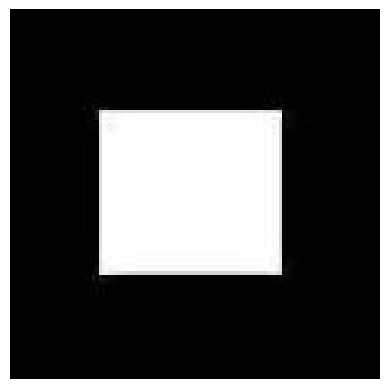

In [71]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = cv2.imread("./square.jpg")
img_rgb = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_gray = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

img_gray = 0.5*(img_gray + 255.0)

plt.imshow(img_gray, cmap='gray')
plt.axis('off')

(-0.5, 116.5, 116.5, -0.5)

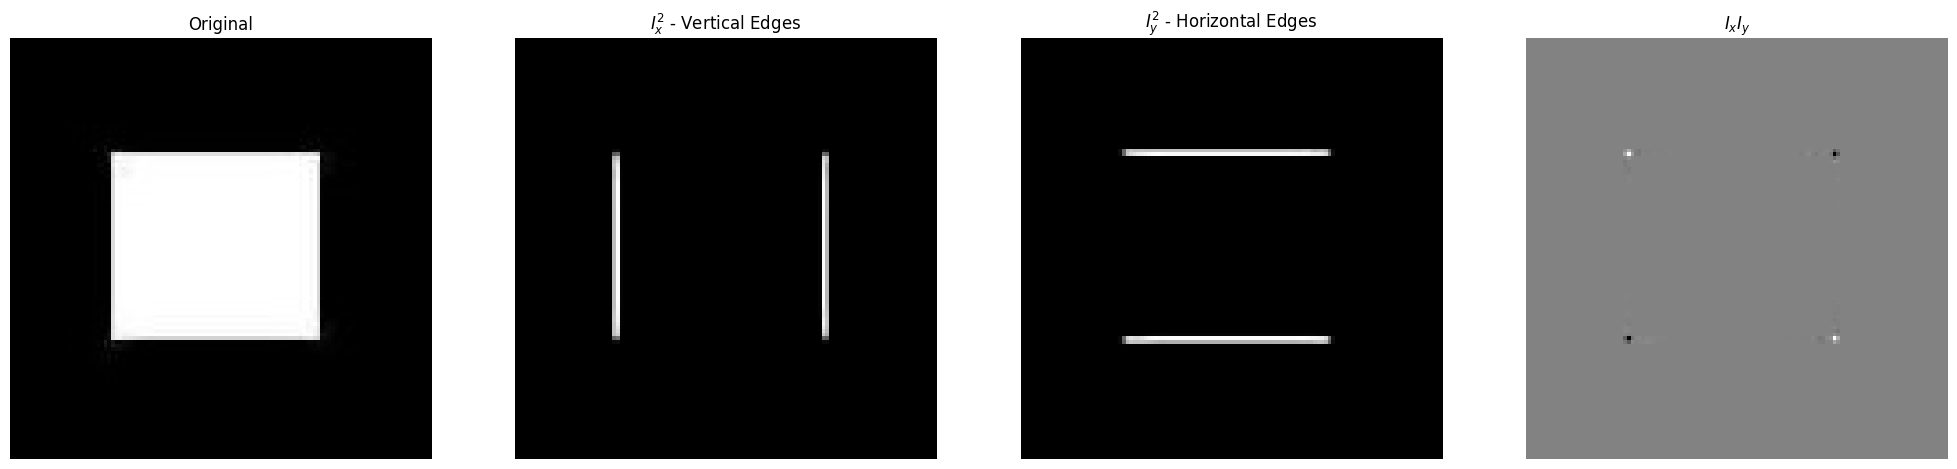

In [80]:
# 3x3 sobel kernels for x and y derivatives
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = np.array([[1,   2,  1],
                    [0,   0,  0],
                    [-1, -2, -1]])

# image derivatiive in x and y directions
Ix = cv2.filter2D(img_gray, -1, sobel_x)              
Iy = cv2.filter2D(img_gray, -1, sobel_y)             

fig,axs = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(25)

plt.subplot(1,4,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(Ix*Ix, cmap='gray')
plt.title('$I_x^2$ - Vertical Edges')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(Iy*Iy, cmap='gray')
plt.title('$I_y^2$ - Horizontal Edges')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(Ix*Iy, cmap='gray')
plt.title('$I_x I_y$')
plt.axis('off')


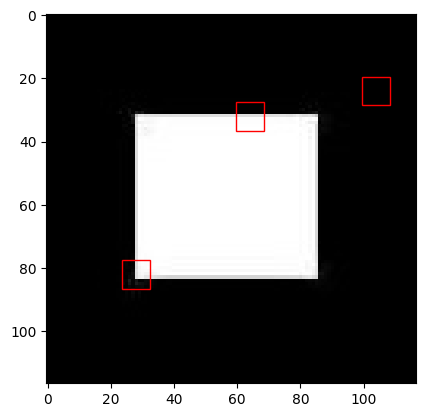

In [127]:
# corner detection window (uniform)
w = np.ones(shape=(9,9)) / (9*9)

# Create windows at the specified pixel coordinates
x1, y1 = 24, 78 
square1 = patches.Rectangle((x1-0.5, y1-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x2, y2 = 60, 28
square2 = patches.Rectangle((x2-0.5, y2-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x3, y3 = 100, 20
square3 = patches.Rectangle((x3-0.5, y3-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')

# show the image
plt.imshow(img_gray, cmap='gray')
# overlay a red square centered at (x,y)
plt.gca().add_patch(square1)
plt.gca().add_patch(square2)
plt.gca().add_patch(square3)

In [139]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos
    wy = w.shape[0]
    wx = w.shape[1]

    Ixx = 0.0
    Iyy = 0.0
    Ixy = 0.0
    #print(f"pos: {pos}")
    x_lo = max(0, x-int(wx/2))
    y_lo = max(0, y-int(wy/2))
    x_lo = max(0, x-int(wx/2))
    y_lo = max(0, y-int(wy/2))

    for i in range(wy):
        for j in range(wx):
            yp = max(0, y-int(wy/2)+i)
            xp = max(0, x-int(wx/2)+j)
            #print(f"i: {i}, j: {j}")
            #print(f"xp; {xp}, yp: {yp}")
            Ixx += w[i,j] * Ix[yp, xp]**2 
            Iyy += w[i,j] * Iy[yp, xp]**2 
            Ixy += w[i,j] * Ix[yp, xp] * Iy[yp, xp]
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    

#### We place windows around 3 different regions: 1) corner region,  2) edge region and 3) uniform region

#### Then we compute the auto-correlation matrix for each window and then look at the eigenvalues

In [129]:
pos1 = (24, 78) # corner region
M1 = compute_M(Ix, Iy, w, pos1)

pos2 = (60, 28) # edge region
M2 = compute_M(Ix, Iy, w, pos2)

pos3 = (100, 20) # uniform region
M3 = compute_M(Ix, Iy, w, pos3)

# eighenvalues of M1, M2 and M3
lambda_M1 = np.linalg.eigvals(M1)
lambda_M2 = np.linalg.eigvals(M2)
lambda_M3 = np.linalg.eigvals(M3)

print(f"Eigenvalues of M in corner region: {lambda_M1}")
print(f"Eigenvalues of M in edge region: {lambda_M2}")
print(f"Eigenvalues of M in uniform region: {lambda_M3}")


Eigenvalues of M in corner region: [4.87436794e+04 7.27739248e+00]
Eigenvalues of M in edge region: [    0.         50128.88888889]
Eigenvalues of M in uniform region: [0.00617284 0.        ]


#### For the window containing the corner region, located at pixel coordinates (24, 78), the eigenvalues of M are $\lambda_1 = 3.9\times10^6$ and $\lambda_2 = 5.9\times10^2$. 

#### In contrast, for the windows containing the edge region,  $\lambda_1 = 0$ and $\lambda_2 = 4.0\times10^6$, i.e. $\lambda_2 >> \lambda_1$. And for the uniform region,  $\lambda_2 \approx \lambda_1 \approx 0$.

#### So if the window contains a corner, then we can expect both eigenvalues to be large, otherwise both eigenvalues will be small or there will be large discrepency between them. 

#### Can design a "corner response function" that make use of these effects, e.g. the Harris reponse function which is defined as: 

#### $R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2 = det(M) - k (tr(M))^2$, where k is an empirically chosen constant ($0.04 \le k \le 0.06$) 

#### So, we could slide the window over every position in the image and compute the value of R at each position, if the R value exceeds a threshold,it is likely that the window contains a corner.

In [125]:
def harris_corner_response(M, k=0.04):
    R = np.linalg.det(M) - k * np.trace(M)**2 
    return R

In [130]:
pos1 = (24, 78) # corner region
M1 = compute_M(Ix, Iy, w, pos1)
R1 = harris_corner_response(M1)

pos2 = (60, 28) # edge region
M2 = compute_M(Ix, Iy, w, pos2)
R2 = harris_corner_response(M2)

pos3 = (100, 20) # uniform region
M3 = compute_M(Ix, Iy, w, pos3)
R3 = harris_corner_response(M3)

print(f"R value in corner region: {R1}")
print(f"R value in edge region: {R2}")
print(f"R value in uniform region: {R3}")

R value in corner region: -94711504.63222077
R value in edge region: -100516220.04938273
R value in uniform region: -1.5241579027587257e-06


#### Now lets write a function that creates a corner map for a given image

In [168]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos
    wy = w.shape[0]
    wx = w.shape[1]

    Ixx = 0.0
    Iyy = 0.0
    Ixy = 0.0
  
    for i in range(wy):
        for j in range(wx):
            yp = y - int(wy/2) + i
            xp = x - int(wx/2) + j
            #print(f"i: {i}, j: {j}")
            #print(f"xp; {xp}, yp: {yp}")
            Ixx += w[i,j] * Ix[yp, xp]**2 
            Iyy += w[i,j] * Iy[yp, xp]**2 
            Ixy += w[i,j] * Ix[yp, xp] * Iy[yp, xp]
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    


def harris_corner_response(M, k=0.04):
    R = np.linalg.det(M) - k * np.trace(M)**2 
    return R


def non_maximal_suppression(img, wsize=5):
    
    w2 = int(wsize/2)
    
    for i in range(w2, img.shape[0]-w2):
        for j in range(w2, img.shape[1]-w2):
            window = img[i-w2:i+w2, j-w2:j+w2]
            maxval = np.max(window)
            window[window < maxval] = 0.0
            img[i-w2:i+w2, j-w2:j+w2] = window         

    return img    


def corner_map(img, window_size = 9, thr_p=0.1, non_max_suppression=False):

    # 3x3 sobel filters for computing derivatives
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])

    sobel_y = np.array([[1,   2,  1],
                        [0,   0,  0],
                        [-1, -2, -1]])

    # image derivatiive in x and y directions
    Ix = cv2.filter2D(img, -1, sobel_x)              
    Iy = cv2.filter2D(img, -1, sobel_y)  

    # pad the derivative maps to make them compatible with windowing
    w2 = int(window_size/2)
    Ix_padded = np.zeros(shape=(Ix.shape[0]+2*w2, Ix.shape[1]+2*w2)) 
    Iy_padded = np.zeros_like(Ix_padded) 
    Ix_padded[w2:w2+Ix.shape[0], w2:w2+Ix.shape[1]] = Ix 
    Iy_padded[w2:w2+Iy.shape[0], w2:w2+Iy.shape[1]] = Iy 

    # corner detection window (uniform)
    w = np.ones(shape=(window_size,window_size)) / (window_size**2)

    R = np.zeros_like(img)

    # iterate over each pixel
    for y in range (img.shape[0]):
        for x in range (img.shape[1]):
            pos = (x,y)
            # compute autocorrelation matrix
            M = compute_M(Ix_padded, Iy_padded, w, pos)
            # compute R value
            R[y,x] = harris_corner_response(M)


    # apply threshold (set threshold to 10% of largest response value)
    thr = thr_p * np.max(R)
    R[R < thr] = 0.0

    if non_max_suppression:
        R = non_maximal_suppression(R)

    return R


(-0.5, 116.5, 116.5, -0.5)

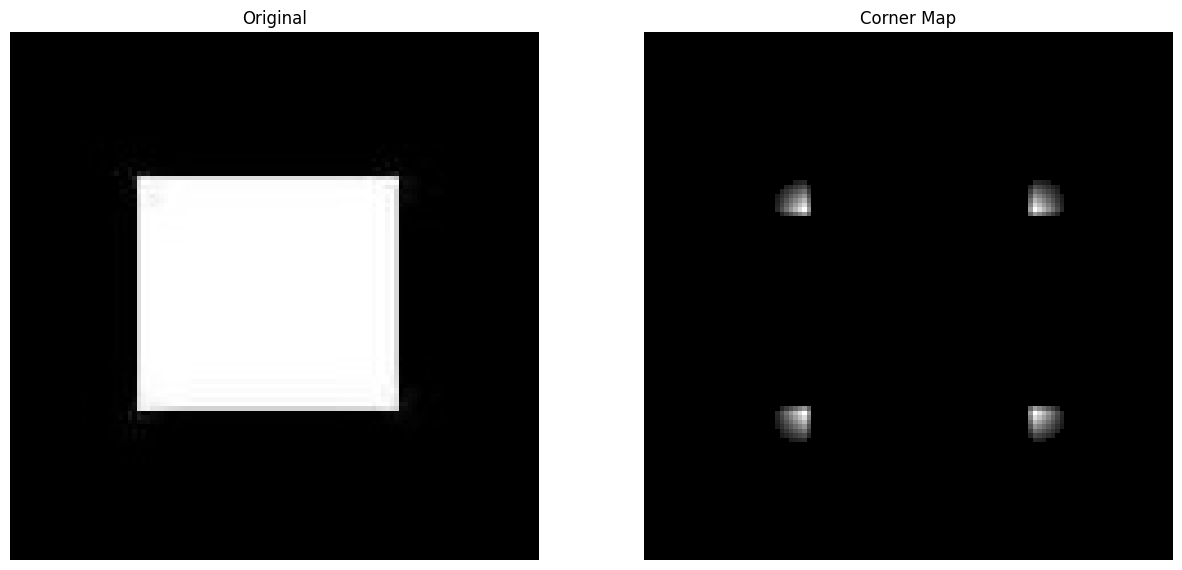

In [169]:
img_corner_map = corner_map(img_gray)

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map')
plt.axis('off')

#### The algorithm is able to detect the corners, however, since we used a large window size, the corner region is also large. To mitigate this, we can reduce the window size and/or use non-maximal suppression.

(-0.5, 116.5, 116.5, -0.5)

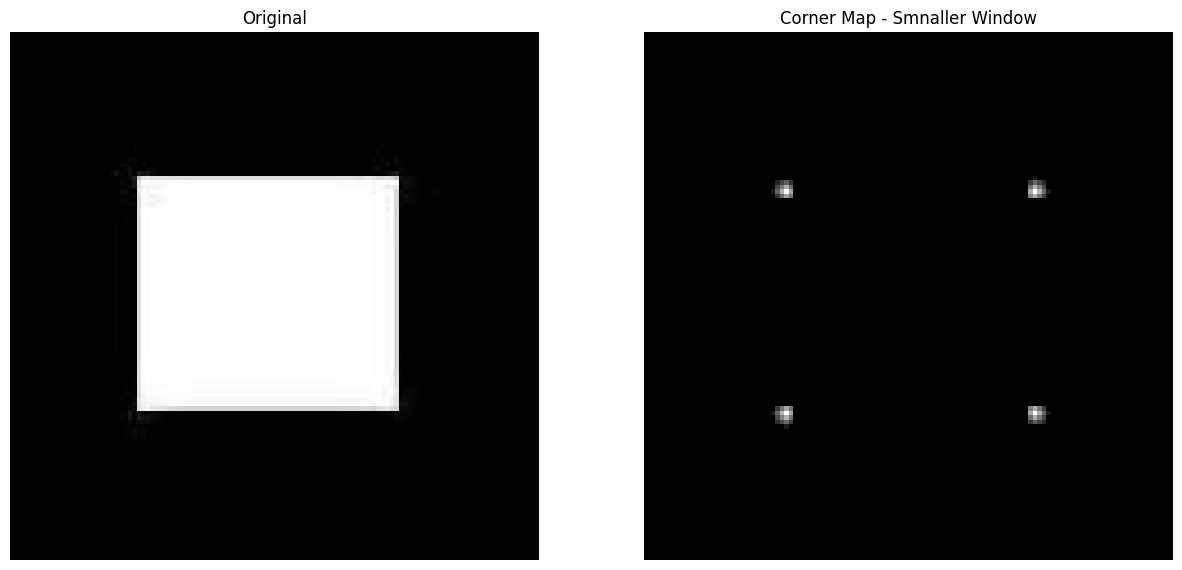

In [174]:
img_corner_map = corner_map(img_gray, window_size=5)


fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map - Smnaller Window')
plt.axis('off')

(-0.5, 116.5, 116.5, -0.5)

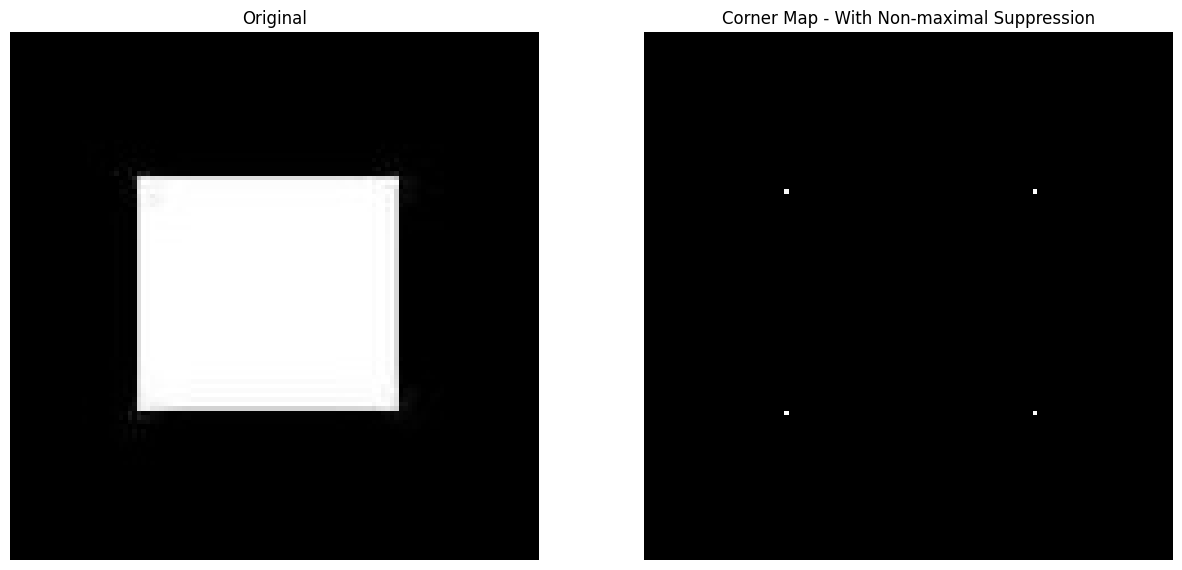

In [175]:
img_corner_map = corner_map(img_gray, window_size=5, non_max_suppression=True)


fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map - With Non-maximal Suppression')
plt.axis('off')
